In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_olivetti_faces
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from tensorly.decomposition import tucker
import tensorly as tl
import matplotlib.pyplot as plt
from scipy.stats import mode
from tensorly import norm
from sklearn.decomposition import PCA

In [2]:
dataset = fetch_olivetti_faces(shuffle=True, random_state=42)
images = dataset.images


In [3]:
images.shape

(400, 64, 64)

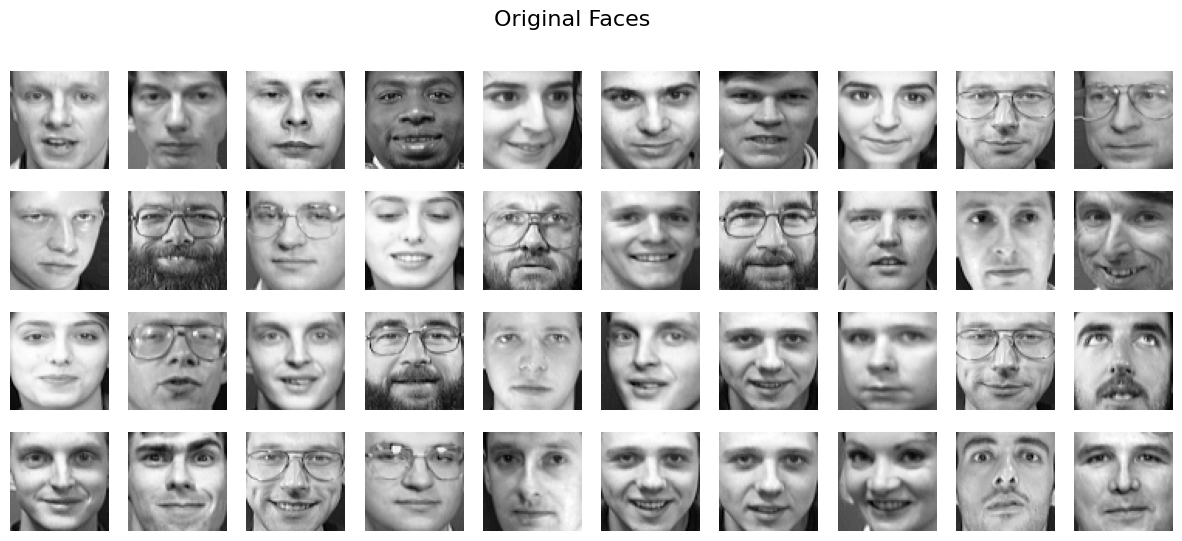

In [4]:
fig, axes = plt.subplots(4, 10, figsize=(15, 6))
fig.suptitle('Original Faces', fontsize=16)
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i], cmap='gray')
    ax.axis('off')

In [5]:
n_samples, height, width = images.shape
images_flatten = images.reshape((n_samples, height * width))
n_components = 250
pca = PCA(n_components=n_components)
images_pca = pca.fit_transform(images_flatten)
pca_reconstructed = pca.inverse_transform(images_pca)
images_pca_reconstructed = pca_reconstructed.reshape((n_samples, height, width))
explained_variance = np.sum(pca.explained_variance_ratio_)
print(f"Explained Variance Ratio with {n_components} components: {explained_variance:.2f}")

Explained Variance Ratio with 250 components: 0.99


In [6]:
# Perform Tucker decomposition 
core, factors = tucker(images, rank=[400, 40, 40])
images_tucker_reconstructed = tl.tucker_to_tensor((core, factors))
variance_explained_tucker = norm(images_tucker_reconstructed) ** 2/norm(images) ** 2
print("Explained Variance Ratio (Tucker):", variance_explained_tucker)


Explained Variance Ratio (Tucker): 0.9993147888210503


In [7]:
pca_reconstruction_error = np.mean((images - images_pca_reconstructed) ** 2)
tucker_reconstruction_error = np.mean((images - images_tucker_reconstructed) ** 2)

print(f"PCA Reconstruction Error: {pca_reconstruction_error:.4f}")
print(f"Tucker Reconstruction Error: {tucker_reconstruction_error:.4f}")

PCA Reconstruction Error: 0.0002
Tucker Reconstruction Error: 0.0002


In [8]:
print("Compression Rate:")
pca_compression_rate = n_components / images.shape[1]
tucker_compression_rate = (np.prod(core.shape) + sum(f.shape[1] for f in factors)) / np.prod(images.shape)
print(f"PCA Compression Rate: {pca_compression_rate:.4f}")
print(f"Tucker Compression Rate: {tucker_compression_rate:.4f}")

Compression Rate:
PCA Compression Rate: 3.9062
Tucker Compression Rate: 0.3909


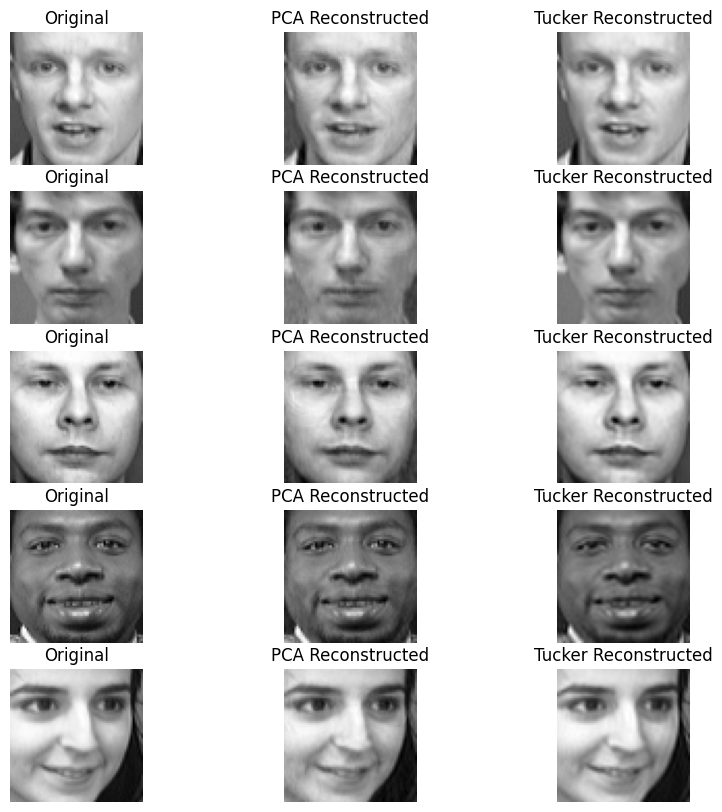

In [9]:
n_plot = 5
fig, axes = plt.subplots(n_plot, 3, figsize=(10, 10))
for i in range(n_plot):
    axes[i, 0].imshow(images[i], cmap='gray')
    axes[i, 0].set_title('Original')
    axes[i, 1].imshow(images_pca_reconstructed[i], cmap='gray')
    axes[i, 1].set_title('PCA Reconstructed')
    axes[i, 2].imshow(images_tucker_reconstructed[i], cmap='gray')
    axes[i, 2].set_title('Tucker Reconstructed')
    for ax in axes[i]:
        ax.axis('off')

# Tensor in NLP

In [10]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from sklearn.metrics import accuracy_score
from nltk.tokenize import word_tokenize
from torch.nn.utils.rnn import pad_sequence
from sklearn.model_selection import train_test_split
from torch import tensor


In [11]:
class ClassificationDataset(Dataset):
    def __init__(self, tokenizer, file_path):
        self.tokenizer = tokenizer
        self.samples = []
        df = pd.read_csv(file_path)
        for _, row in df.iterrows():
            text = row['text']
            label = row['label']
            if isinstance(text, str) and len(text.strip()) > 0:
                self.samples.append((int(label), text))
                
    def __len__(self):
        return len(self.samples)

    def __getitem__(self, index):
        label, text = self.samples[index]
        input_ids = torch.tensor(self.tokenizer.encode(text), dtype=torch.long)
        label_tensor = torch.tensor(label, dtype=torch.long)
        return input_ids, label_tensor
    

class SimpleTokenizer:
    def __init__(self, text):
        self.vocab = set()
        self.stoi = {}
        self.itos = {}
        self.build_vocab(text)

    def build_vocab(self, text):
        tokens = word_tokenize(text)
        self.vocab = set(tokens)
        self.vocab_size = len(self.vocab) + 2
        self.stoi = {word: i for i, word in enumerate(self.vocab, start=2)}
        self.stoi['<pad>'] = 0
        self.stoi['<unk>'] = 1
        self.itos = {i: word for word, i in self.stoi.items()}

    def encode(self, text):
        tokens = word_tokenize(text)
        return [self.stoi.get(word, self.stoi['<unk>']) for word in tokens]

    def decode(self, indices):
        return ' '.join([self.itos.get(index, '<unk>') for index in indices])
    

def collate_batch(batch):
    input_ids, labels = zip(*batch)
    input_ids_padded = pad_sequence(input_ids, batch_first=True, padding_value=0)
    labels = torch.stack(labels)
    return input_ids_padded, labels


class ClassificationModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim=128, hidden_dim=64, output_dim=6):
        super(ClassificationModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.fc1 = nn.Linear(embedding_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, input_ids):
        embedded = self.embedding(input_ids)
        pooled = embedded.mean(dim=1)
        hidden = self.relu(self.fc1(pooled))
        output = self.fc2(hidden)
        return output

In [12]:
data = pd.read_parquet("train-00000-of-00001.parquet")
data, _ = train_test_split(data, test_size=0.6, random_state=42)
train_data,test_data=  train_test_split(data, test_size=0.3, random_state=42)
train_data.to_csv("train_data.csv", index=False)
test_data.to_csv("test_data.csv", index=False)


In [13]:
texts=[]
with open('train_data.csv', 'r', encoding='utf-8') as file:
    texts.append(file.read())
with open('test_data.csv', 'r', encoding='utf-8') as file:
    texts.append(file.read())

tokenizer = SimpleTokenizer(' '.join(texts))
tokenizer.vocab_size


77095

In [14]:
train_dataset = ClassificationDataset(tokenizer, "train_data.csv")
train_loader = DataLoader(train_dataset, batch_size=32, collate_fn=collate_batch ,shuffle=True)

test_dataset= ClassificationDataset(tokenizer, "test_data.csv")
test_loader = DataLoader(test_dataset, batch_size=32, collate_fn=collate_batch ,shuffle=True)

In [15]:
vocab_size = tokenizer.vocab_size
model = ClassificationModel(vocab_size)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(15):  
    for input_ids, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(input_ids)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

print("Training complete.") 

Training complete.


In [16]:
all_preds = []
all_labels = []
with torch.no_grad():
    for input_ids, labels in test_loader:
        outputs = model(input_ids)
        _, preds = torch.max(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 88.62%


# Tensor in Computer vision

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [18]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = torchvision.datasets.MNIST(root='.', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='.', train=False, download=True, transform=transform)

In [19]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [20]:
class LinearModel(nn.Module):
    def __init__(self):
        super(LinearModel, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [21]:
model = LinearModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
train_loss_history = []
val_accuracy_history = []
for epoch in range(5):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss_history.append(running_loss / len(train_loader))
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_accuracy = correct / total
    val_accuracy_history.append(val_accuracy)
    
    print(f"Epoch [{epoch+1}/{5}], Loss: {running_loss / len(train_loader):.4f}, Validation Accuracy: {val_accuracy:.4f}")

Epoch [1/5], Loss: 0.7493, Validation Accuracy: 0.8870
Epoch [2/5], Loss: 0.3666, Validation Accuracy: 0.9069
Epoch [3/5], Loss: 0.3214, Validation Accuracy: 0.9161
Epoch [4/5], Loss: 0.2940, Validation Accuracy: 0.9163
Epoch [5/5], Loss: 0.2713, Validation Accuracy: 0.9242
